ENPM673: Perception for Autonomous Robots
Project3

By: Shivam Dhakad

Problem1 Dataset: https://drive.google.com/drive/folders/1QRWZaUvkLn_vJQq0bPVQhtoK0c44-Otx?usp=sharing

In [ ]:
#mounting the drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    FOLDERNAME =  "ENPM673/project3/"
    assert FOLDERNAME is not None, "[!] Enter the foldername."
    %cd drive/My\ Drive
    %cd $FOLDERNAME
except ModuleNotFoundError as ex:
    print("Please run this snippet in Google Colab")

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/ENPM673/project3


In [ ]:
# Import Libraries
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import glob
from time import sleep

##Part1: steps followed to calibrate the camera using checkerboard pattern.

Step1:Image Collection:
Using webcam caputered 64 images of checkerboard of grid size (7,9).Keeping the checkerboard static and an moving the camera to capture images from various angles.

    


Step2:Corner Detection:
Using cv2.findChessboardCorners() function detect the corners of the chessboard in each image.

In [ ]:

# Defining the dimensions of checkerboard
CHECKERBOARD = (7,9) # checker board grid size
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# save vectors of 3D points for each checkerboard image
objpoints = []
# save vectors of 2D points for each checkerboard image
imgpoints = []


# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

# Extracting path of individual image stored in a given directory
images = glob.glob('./problem1_dataset/*.jpg')

original_images_cornerpts = []  # save corner points detected in original image
img_with_corners_detected =[]  # save images with corner points drawn on them

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # detect checkerboard corners points
    ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD, cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)

    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        original_images_cornerpts.append(corners2)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
        img_with_corners_detected.append(img)
    # cv.imshow('img',img)
    # cv.waitKey(100)
    # cv.destroyAllWindows()
# cv.destroyAllWindows()



Step3:Calculating intrinsic paramenters of camera: estimates camera matrix,focal length, principal point, and distortion coefficients, using a set of calibration images and corresponding object points (3D points in the world coordinate system) and image points (2D points in the image plane).



In [ ]:
#calculate camera matrix and distortion coeffecients
h,w = img.shape[:2]
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera matrix : \n")
print(mtx)
print("distortion_coefficient : \n")
print(dist)

Camera matrix : 

[[819.07615792   0.         470.35777655]
 [  0.         812.5399475  370.73092774]
 [  0.           0.           1.        ]]
distortion_coefficient : 

[[ 2.48353097e-02  2.53931565e-01  5.62004884e-04 -1.30980827e-04
  -1.49837064e+00]]


Step4: Based on calculated camera matrix and distrotion coefficeint, undistorte the image.

In [ ]:
# step2
# undistorting the images
i = 0
undistorted_image_list = []
for fname in images:
    i += 1
    h, w = img.shape[:2]
    original_image = cv.imread(fname)
    # print("h,w of frame", i,"is :", h,w)
    print("image_number:", i)

    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    #saving undistorted images in a list for final visulatization purpose
    undistorted_image_list.append(dst)

    undistorted_image = dst
    # Create a figure for plotting
    fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

    # Display original image in first subplot
    ax1.imshow(original_image)
    ax1.set_title('Original Image')
    ax1.axis('off')  # Hide axes for cleaner presentation

    # Display modified image in second subplot
    ax2.imshow(undistorted_image)
    ax2.set_title('Undistorted_Image')
    ax2.axis('off')  # Hide axes for cleaner presentation
    plt.tight_layout()
    # Display the final plot with both images
    # plt.show()
    plt.pause(1)
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

Step5: Reprojection Error: based on image object points, calcualted in previous step and, the roational and translation vectors, estimate the error in shift of corner points in original image and undistorted image.



total error: 0.09708083380521784


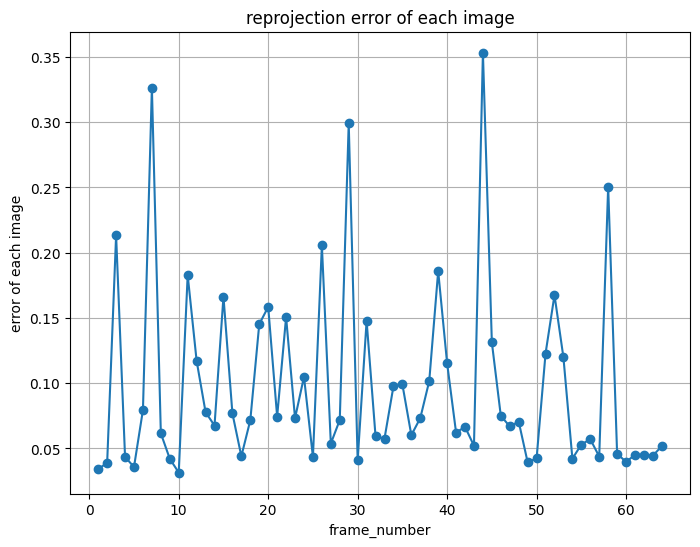

In [ ]:
#calculating reprojection error
error_4each_frame = []
mean_error = 0
for i in range(len(objpoints)):
 imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
 error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
 error_4each_frame.append(error)
 mean_error += error

print( "total error: {}".format(mean_error/len(objpoints)) )
#plot error for each image
plt.figure(figsize=(8,6))
plt.plot(range(1,len(images)+1), error_4each_frame, marker = 'o')
plt.xlabel("frame_number")
plt.ylabel('error of each image')
plt.title("reprojection error of each image")
plt.grid(True)
plt.show()

Reprojection Error analysis:
It is observed the points in  the image which are farthes from the center of  the image plane have significant shift from the straight line.
       
Additionally, in the images captured with image plane directly parallel checker boardpattern have small reprojection error, whereas in the images which were capture with angled image plane have maximum reprojection error.

In [ ]:
# detect and save the corner points in undistorted frame
corner_from_undistortedimg_list = []
undistorted_image_list
for fname in undistorted_image_list:
    # img = cv.imread(fname)
    img = fname
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD, cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_FAST_CHECK + cv.CALIB_CB_NORMALIZE_IMAGE)

    if ret == True:
        objpoints.append(objp)
        print("true")
        # refining pixel coordinates for given 2d points.
        corners2 = cv.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        corner_from_undistortedimg_list.append(corners2)



In [ ]:

# visualizing calibration results
# plotting undistorted_image-corner points (green) on origianl image
#original corner points are represented by points in rainbow cour shade connected with the lines

ig = 0 # image number to be plotted
# Plot the points with markers and desired color
for point_tuple in original_images_cornerpts:
# for point_tuple in corner_from_undistortedimg_list:

    fig, ax = plt.subplots()
    print("image_number",ig)
    # plt_on_images = img_with_corners_detected[ig]

    plt_on_images = undistorted_image_list[ig]

    # Display the image
    ax.imshow(plt_on_images)
    # print("tuple",point_tuple)

    for points in point_tuple:
        for each_coordinates in points:
            x, y = each_coordinates
            ax.plot(x, y, marker='o', color='green', linestyle='', markersize=4)
            # plt.title("image number",ig)

    ax.set_xlim(0, plt_on_images.shape[1])
    ax.set_ylim(plt_on_images.shape[0], 0)
    plt.show()
    ig +=1

# Set plot title and labels (optional)
plt.title("Image with Points")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
image = img

# Adjust axis limits to fit the image (optional)
ax.set_xlim(0, image.shape[1])
ax.set_ylim(image.shape[0], 0)  # In Matplotlib, y increases downwards

# Show the plot
plt.show()


Output hidden; open in https://colab.research.google.com to view.

It is observed the points in  the image which are farthes from the center of  the image plane have significant shift from the straight line.
       
Additionally, in the images captured with image plane directly parallel checker boardpattern have small reprojection error, whereas in the images which were capture with angled image plane have maximum reprojection error.